In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/ultralytics/yolov5


In [ ]:
!pip install -r yolov5/requirements.txt

In [ ]:
!unzip 'archive.zip'

In [25]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"licence": 0}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))
class_name_to_id_mapping = {"licence": 0}

In [ ]:
# Get the annotations

annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()
print(os.path.join('annotations'))

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

annotations


100%|██████████| 433/433 [00:02<00:00, 168.09it/s]


Testing the annotations


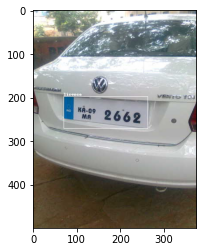

In [ ]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

Partition the Dataset


In [ ]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

Create the folders to keep the splits.



In [ ]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test


In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

Rename the annotations folder to labels, as this is where YOLO v5 expects the annotations to be located in.

In [ ]:
!mv annotations labels
!cd yolov5 

/bin/bash: line 0: cd: yolov5: No such file or directory


In [12]:
cd yolov5


/content/drive/MyDrive/yolov5


In [ ]:
!wget -P data/ https://gist.githubusercontent.com/ayooshkathuria/bcf7e3c929cbad445439c506dba6198d/raw/f437350c0c17c4eaa1e8657a5cb836e65d8aa08a/road_sign_data.yaml

Training

In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 16 --epochs 100 --data road_sign_data.yaml --weights yolov5s.pt --workers 12 --name yolo_road_det 

Inference

In [ ]:
!python detect.py --source ../Car.mp4  --weights runs/train/yolo_road_det/weights/best.pt --conf 0.25 --name yolo_road_det --save-txt


In [ ]:
detections_dir = "runs/detect/yolo_road_det/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [ ]:
!unzip 'Dataset1.zip'



In [ ]:
cd yolov5

/content/drive/MyDrive/yolov5


In [ ]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
labels = [os.path.join('labels', x) for x in os.listdir('labels') if x[-3:] == "txt"]

images.sort()
labels.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, labels, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
!mkdir images/train images/val images/test labels/train labels/val labels/test

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'labels/train/')
move_files_to_folder(val_annotations, 'labels/val/')
move_files_to_folder(test_annotations, 'labels/test/')

In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [ ]:
!pip install -r yolov5/requirements.txt


In [84]:
cd  /content/drive/MyDrive/Dataset1/yolov5

/content/drive/MyDrive/Dataset1/yolov5


In [ ]:
!wget -P data/ https://gist.githubusercontent.com/ayooshkathuria/bcf7e3c929cbad445439c506dba6198d/raw/f437350c0c17c4eaa1e8657a5cb836e65d8aa08a/road_sign_data.yaml

In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 200 --data road_sign_data.yaml --weights yolov5s.pt --workers 12 --name yolo_road_det


In [ ]:
cd content/drive/MyDrive/yolov5

/content/drive/MyDrive/yolov5


In [ ]:
!python detect.py --source ../caar.mp4  --weights runs/train/yolo_road_det/weights/best.pt --conf 0.25 --name yolo_road_det --save-txt --save-conf


In [ ]:
cd /content/drive/MyDrive/Dataset1/yolov5

/content/drive/MyDrive/Dataset1/yolov5


In [78]:
def plate_reader(file):
  plate=''
  list_of_dict=[]
  with open(file,'r') as f:
    for line in f:
        array=[]
        
        for word in line.split():
           array.append(word)
        dict={'class':array[0],'x':array[1]}
        list_of_dict.append(dict)
  list_of_dict= sorted(list_of_dict, key=lambda d: d['x'])
  char_classes = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',10:'alef',11:'b',12:'j',13:'l',14:'m',15:'n',16:'q',17:'v',18:'h',19:'y',20:'d',21:'s',22:'sad',23:'malol',24:'t',25:'ta',26:'ein',27:'diplomat',28:'siyasi',29:'p',30:'tashrifat',31:'the',32:'ze',33:'she',34:'fe',35:'kaf',36:'gaf'}
  for i in list_of_dict:
      plate+=(char_classes.get(int(i['class'])))
  return plate
    

In [ ]:
char_classes = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',10:'alef',11:'b',12:'j',13:'l',14:'m',15:'n',16:'q',17:'v',18:'h',19:'y',20:'d',21:'s',22:'sad',23:'malol',24:'t',25:'ta',26:'ein',27:'diplomat',28:'siyasi',29:'p',30:'tashrifat',31:'the',32:'ze',33:'she',34:'fe',35:'kaf',36:'gaf'}
char_classes.values()

dict_values(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'alef', 'b', 'j', 'l', 'm', 'n', 'q', 'v', 'h', 'y', 'd', 's', 'sad', 'malol', 't', 'ta', 'ein', 'diplomat', 'siyasi', 'p', 'tashrifat', 'the', 'ze', 'she', 'fe', 'kaf', 'gaf'])

In [79]:
from PIL import Image
def detect_image():
  path1="/content/drive/MyDrive/yolov5"
  path2="/content/drive/MyDrive/Dataset1/yolov5"
  os.chdir(path1)
  !python detect.py --source ../Car.jpg  --weights runs/train/yolo_road_det/weights/best.pt --conf 0.25 --name final1 --save-crop --project ../Part1

  os.chdir(path2)
  !python detect.py --source ../../Part1/final/crops/lisence/Car.jpg --weights runs/train/yolo_road_det/weights/best.pt --name final1 --save-txt --project ../../Part2
  print(plate_reader('/content/drive/MyDrive/Part2/final1/labels/Car.txt'))


In [ ]:

detect_image()